<a href="https://colab.research.google.com/github/smarulandas/TEORIA_DE_SENALES/blob/main/PROMTS_PSD%26POINT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

PSD AND POINT ESTIMATION NOTEBOOK

1) Create a Python class called SignalGenerator that generates signals with multiple harmonics and Gaussian noise. The class must include: 1) A constructor that receives sampling frequency and number of samples, 2) A generate_signal method that takes amplitudes/frequencies of 3 harmonics and noise variance, returning arrays of time, clean signal and signal with noise, 3) A plot_signal method to visualize both signals. Then implement a main function that uses this class with configurable parameters (sample rate=1000Hz, 2000 samples, amplitudes [1,0,0], frequencies [10,30,60]Hz, no noise) and display the results. Use numpy for calculations and matplotlib for graphics, with clean code style and proper documentation.

2) Continue with the previous code without modifications and give all code (previous + next), generate in a function the histogram signal  (use only positive values) and in the same histogram overlay the KDE of the signal and in an other function estimate the PSD of the signal using Welch method (nperseg modifiable parameter in main and by default 1024) and plot the PSD where y axis must be in dB (10log()) and x axis in semilogx.

3) Continue with the previous code without modifications and give all code (previous + next), now I need you to generate 100 realizations and find the maximum value, i.e. I need you to calculate the peak value of the signal with noise 100 times, add the KDE and overlay in the histogram, add the following graphs in a subplot: 2 rows and 2 columns (signal with harmonics and noise, Histogram of noisy signal with KDE, PSD welch method, distribution of peak values (100 realizations)), also print the next peak value stadistics (mean,meedian, variance) and realize kolmogrov smirnov gaussivity test.

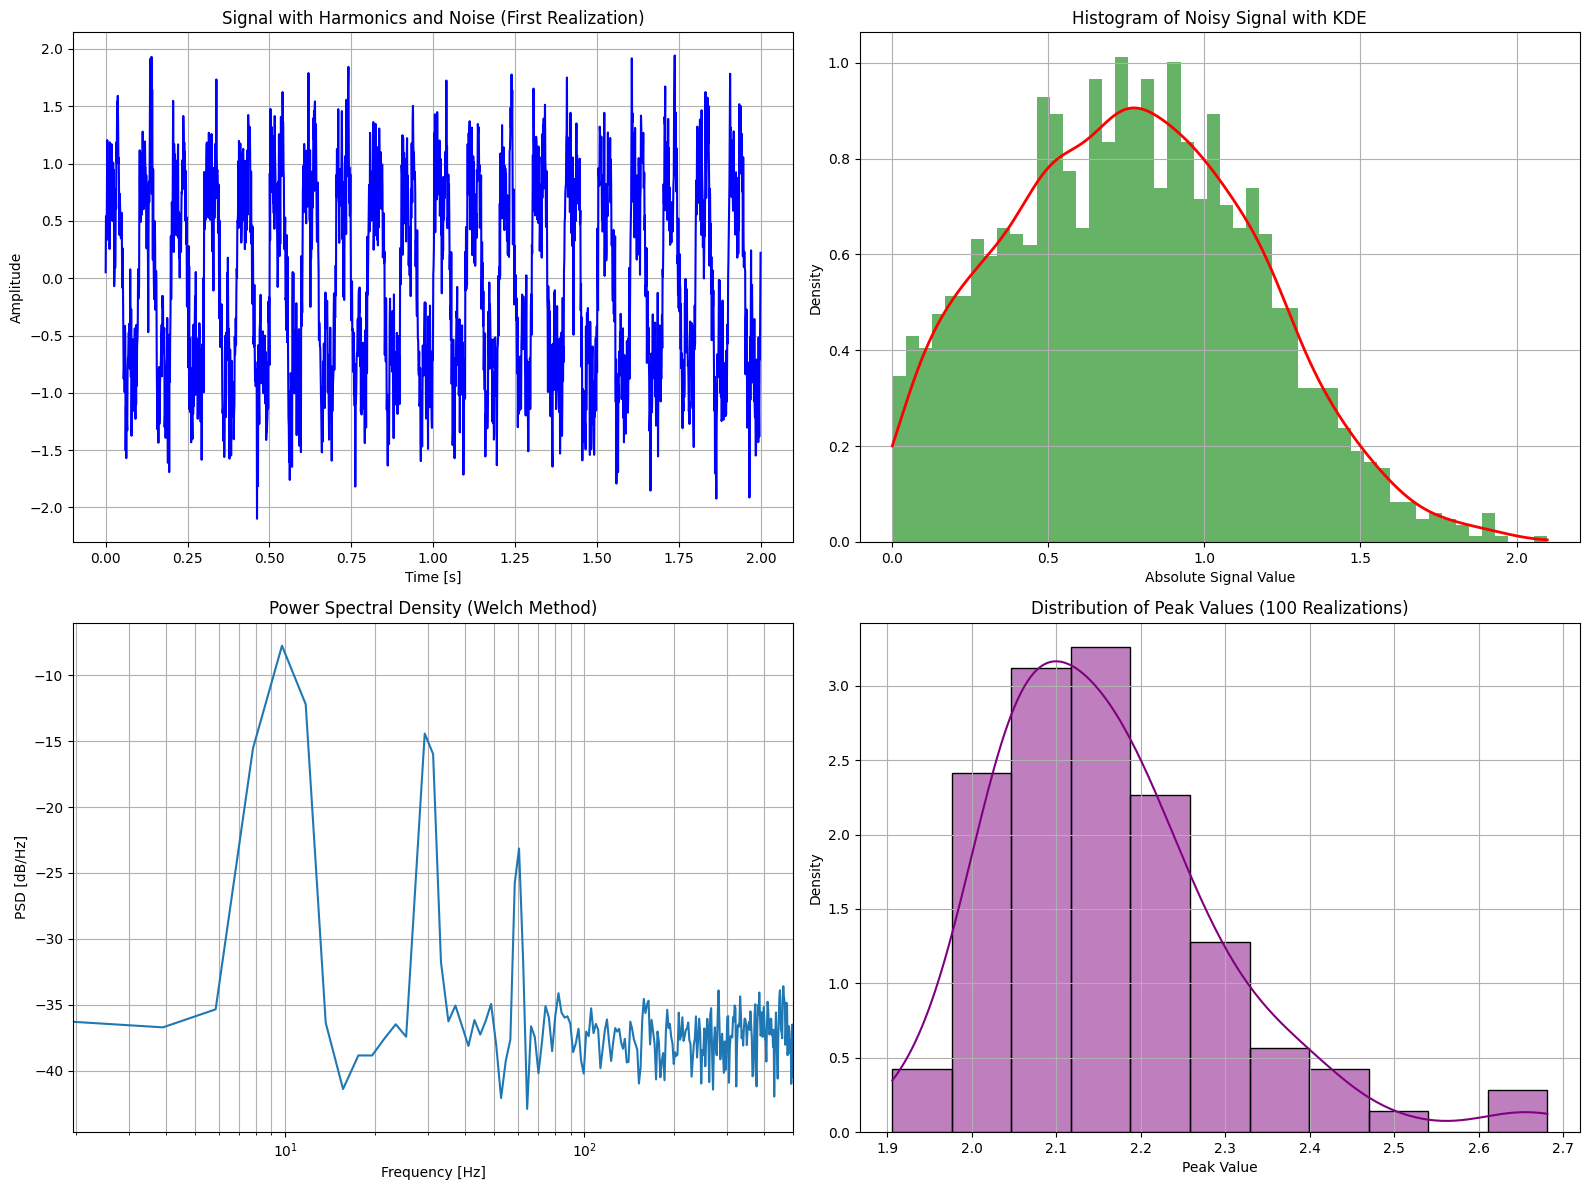


Peak Value Statistics:
Mean: 2.1586
Median: 2.1369
Variance: 0.0181
Standard Deviation: 0.1346
Minimum: 1.9059
Maximum: 2.6814

Normality Test (Kolmogorov-Smirnov):
KS Statistic: 0.0899
P-value: 0.3724
Result: Distribution is normal (fail to reject H0)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.stats import gaussian_kde, kstest, norm
import seaborn as sns


class SignalGenerator:
    """
    A class to generate signals composed of multiple harmonics with optional Gaussian noise.

    Attributes:
        fs (float): Sampling frequency in Hz
        num_samples (int): Number of samples to generate
        time (np.ndarray): Array of time values for the signal
    """

    def __init__(self, sampling_frequency: float, num_samples: int):
        """
        Initialize the SignalGenerator with sampling parameters.

        Args:
            sampling_frequency: The sampling frequency in Hz
            num_samples: The number of samples to generate
        """
        self.fs = sampling_frequency
        self.num_samples = num_samples
        self.time = np.arange(num_samples) / sampling_frequency

    def generate_signal(self, amplitudes: list, frequencies: list, noise_variance: float = 0.0):
        """
        Generate a signal composed of harmonics with optional Gaussian noise.

        Args:
            amplitudes: List of amplitudes for each harmonic (up to 3)
            frequencies: List of frequencies for each harmonic in Hz (up to 3)
            noise_variance: Variance of the Gaussian noise to add

        Returns:
            tuple: (time_array, clean_signal, noisy_signal)
        """
        if len(amplitudes) != 3 or len(frequencies) != 3:
            raise ValueError("Amplitudes and frequencies must have exactly 3 elements")

        clean_signal = np.zeros_like(self.time)

        # Generate each harmonic component
        for amp, freq in zip(amplitudes, frequencies):
            if freq > self.fs / 2:
                raise ValueError(f"Frequency {freq}Hz exceeds Nyquist frequency ({self.fs/2}Hz)")
            if amp != 0 and freq != 0:  # Skip if amplitude or frequency is zero
                clean_signal += amp * np.sin(2 * np.pi * freq * self.time)

        # Add Gaussian noise
        noise = np.random.normal(0, np.sqrt(noise_variance), self.num_samples)
        noisy_signal = clean_signal + noise

        return self.time, clean_signal, noisy_signal

    def plot_signal(self, time, clean_signal, noisy_signal, title="Generated Signal"):
        """
        Plot both clean and noisy signals.

        Args:
            time: Time array
            clean_signal: Clean signal without noise
            noisy_signal: Signal with noise added
            title: Plot title
        """
        plt.figure(figsize=(12, 6))

        plt.subplot(2, 1, 1)
        plt.plot(time, clean_signal, label='Clean Signal', color='blue')
        plt.title(f"{title} (Clean)")
        plt.xlabel('Time [s]')
        plt.ylabel('Amplitude')
        plt.grid(True)
        plt.legend()

        plt.subplot(2, 1, 2)
        plt.plot(time, noisy_signal, label='Noisy Signal', color='red', alpha=0.7)
        plt.title(f"{title} (Noisy)")
        plt.xlabel('Time [s]')
        plt.ylabel('Amplitude')
        plt.grid(True)
        plt.legend()

        plt.tight_layout()
        plt.show()

    def plot_histogram_with_kde(self, signal_data, title="Signal Histogram with KDE"):
        """
        Plot histogram of signal values (absolute values only) with KDE overlay.

        Args:
            signal_data: Input signal data
            title: Plot title
        """
        # Take absolute values of the signal
        abs_signal = np.abs(signal_data)

        plt.figure(figsize=(10, 6))

        # Plot histogram
        n, bins, patches = plt.hist(abs_signal, bins=50, density=True,
                                   alpha=0.6, color='g', label='Histogram')

        # Calculate and plot KDE
        kde = gaussian_kde(abs_signal)
        x = np.linspace(0, np.max(abs_signal), 1000)
        plt.plot(x, kde(x), 'r-', linewidth=2, label='KDE')

        plt.title(title)
        plt.xlabel('Absolute Signal Value')
        plt.ylabel('Density')
        plt.grid(True)
        plt.legend()
        plt.show()

    def plot_psd_welch(self, signal_data, nperseg=1024, title="Power Spectral Density (Welch)"):
        """
        Estimate and plot PSD using Welch's method.

        Args:
            signal_data: Input signal data
            nperseg: Length of each segment for Welch's method
            title: Plot title
        """
        # Compute PSD using Welch's method
        f, Pxx = signal.welch(signal_data, self.fs, nperseg=nperseg)

        plt.figure(figsize=(10, 6))

        # Plot PSD in dB with semilog x-axis
        plt.semilogx(f, 10 * np.log10(Pxx))

        plt.title(title)
        plt.xlabel('Frequency [Hz]')
        plt.ylabel('Power Spectral Density [dB/Hz]')
        plt.grid(True, which="both", ls="-")
        plt.xlim([f[1], f[-1]])  # Skip DC component for log scale
        plt.show()


def generate_multiple_realizations(generator, amplitudes, frequencies, noise_variance, num_realizations=100):
    """
    Generate multiple realizations and collect peak values.

    Args:
        generator: SignalGenerator instance
        amplitudes: List of harmonic amplitudes
        frequencies: List of harmonic frequencies
        noise_variance: Noise variance
        num_realizations: Number of realizations to generate

    Returns:
        tuple: (time, clean_signal, noisy_signals, peak_values)
    """
    peak_values = []
    noisy_signals = []

    # Generate first realization to get clean signal and time array
    time, clean_signal, _ = generator.generate_signal(amplitudes, frequencies, noise_variance)

    # Generate multiple realizations
    for _ in range(num_realizations):
        _, _, noisy_signal = generator.generate_signal(amplitudes, frequencies, noise_variance)
        noisy_signals.append(noisy_signal)
        peak_values.append(np.max(np.abs(noisy_signal)))

    return time, clean_signal, noisy_signals, np.array(peak_values)


def plot_comprehensive_analysis(time, clean_signal, noisy_signals, peak_values, nperseg=1024):
    """
    Create a comprehensive 2x2 subplot with all analyses.

    Args:
        time: Time array
        clean_signal: Clean signal without noise
        noisy_signals: List of noisy signals
        peak_values: Array of peak values
        nperseg: Segment length for Welch's method
    """
    plt.figure(figsize=(16, 12))

    # Subplot 1: Signal with harmonics and noise (first realization)
    plt.subplot(2, 2, 1)
    plt.plot(time, noisy_signals[0], color='blue')
    plt.title('Signal with Harmonics and Noise (First Realization)')
    plt.xlabel('Time [s]')
    plt.ylabel('Amplitude')
    plt.grid(True)

    # Subplot 2: Histogram of noisy signal with KDE (first realization)
    plt.subplot(2, 2, 2)
    abs_signal = np.abs(noisy_signals[0])
    n, bins, patches = plt.hist(abs_signal, bins=50, density=True, alpha=0.6, color='g')
    kde = gaussian_kde(abs_signal)
    x = np.linspace(0, np.max(abs_signal), 1000)
    plt.plot(x, kde(x), 'r-', linewidth=2)
    plt.title('Histogram of Noisy Signal with KDE')
    plt.xlabel('Absolute Signal Value')
    plt.ylabel('Density')
    plt.grid(True)

    # Subplot 3: PSD using Welch's method (first realization)
    plt.subplot(2, 2, 3)
    f, Pxx = signal.welch(noisy_signals[0], generator.fs, nperseg=nperseg)
    plt.semilogx(f, 10 * np.log10(Pxx))
    plt.title('Power Spectral Density (Welch Method)')
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('PSD [dB/Hz]')
    plt.grid(True, which="both", ls="-")
    plt.xlim([f[1], f[-1]])

    # Subplot 4: Distribution of peak values
    plt.subplot(2, 2, 4)
    sns.histplot(peak_values, kde=True, color='purple', stat='density')
    plt.title('Distribution of Peak Values (100 Realizations)')
    plt.xlabel('Peak Value')
    plt.ylabel('Density')
    plt.grid(True)

    plt.tight_layout()
    plt.show()


def print_statistics(peak_values):
    """
    Print statistics of peak values and perform normality test.

    Args:
        peak_values: Array of peak values
    """
    print("\nPeak Value Statistics:")
    print(f"Mean: {np.mean(peak_values):.4f}")
    print(f"Median: {np.median(peak_values):.4f}")
    print(f"Variance: {np.var(peak_values):.4f}")
    print(f"Standard Deviation: {np.std(peak_values):.4f}")
    print(f"Minimum: {np.min(peak_values):.4f}")
    print(f"Maximum: {np.max(peak_values):.4f}")

    # Perform Kolmogorov-Smirnov test for normality
    ks_stat, p_value = kstest((peak_values - np.mean(peak_values))/np.std(peak_values), 'norm')
    print("\nNormality Test (Kolmogorov-Smirnov):")
    print(f"KS Statistic: {ks_stat:.4f}")
    print(f"P-value: {p_value:.4f}")
    if p_value > 0.05:
        print("Result: Distribution is normal (fail to reject H0)")
    else:
        print("Result: Distribution is not normal (reject H0)")


def main():
    """
    Main function to demonstrate the comprehensive analysis.
    """
    # Configuration parameters
    sampling_frequency = 1000  # Hz
    num_samples = 2000
    amplitudes = [1, 0.5, 0.2]  # Three harmonics with different amplitudes
    frequencies = [10, 30, 60]  # Frequencies in Hz
    noise_variance = 0.1  # Add some noise
    nperseg = 512  # Segment length for Welch's method
    num_realizations = 100  # Number of realizations

    # Create signal generator
    global generator
    generator = SignalGenerator(sampling_frequency, num_samples)

    # Generate multiple realizations and collect peak values
    time, clean_signal, noisy_signals, peak_values = generate_multiple_realizations(
        generator, amplitudes, frequencies, noise_variance, num_realizations
    )

    # Plot comprehensive analysis
    plot_comprehensive_analysis(time, clean_signal, noisy_signals, peak_values, nperseg)

    # Print statistics and normality test results
    print_statistics(peak_values)


if __name__ == "__main__":
    main()

# FIlter

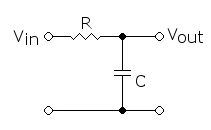


\begin{array}{rcl}
V_{in} & = & I R + \frac{1}{C} \int I dt \\
V_{out} & = & \frac{1}{C} \int I dt \\
\frac{V_{out}}{V_{in}} & = & \frac{\frac{1}{C} \int I dt}{I R + \frac{1}{C} \int I dt} \\
& = & \frac{1}{1 + sRC}
\end{array}

1) Continue with the previous code without modifications and give all the code (previous + next), add in a function that calculates the signal to noise ratio (SNR) and plot it for noise power (it is the same as noise variance) for values of 0.1, 0.2, 0.4, 0.8 and 1.6. and print noise power and SNR values Remember all histograms only positive values

2) Taking into account the previous codes but without implementing them again, generate a Python script using only functions (not a class) that designs passive RC low-pass filter. The filter parameters must be modifiable (capacitance values and desired cut-off frequency), and based on that, the resistance values must be automatically calculated using real commercial component values (not digital filters). The cut-off frequency must be modifiable in the main function. Print the transfer function and plot the magnitude and phase response; on the magnitude plot, add markers for the -3 dB cut-off frequency.

3) Continue with the previous code without modifications and give all the code (previous + next), implement a function to calculate the PSD at the input and output of the filter, using the generated signal as input. Plot in a subplot the input and output PSD(on a single graph, on the x-axis in logarithmic scale and y-axis in decibels, from 0 to -60 db)

4) Continue with the previous code without modifications and provide the complete code (previous + new part). Implement a method  to compute the impulse response of the previous filter  (impulse[0]=1, Normalizes the amplitudes of the impulse response), axis x must be modifiable, generate all the corresponding plots in a single figure using a 2-row by 2-column subplot layout (Bode magnitude plot, Bode phase plot, power spectral density, impulse response).
for the impulse response adds a modifiable time array in main

Designed Second-Order RC Low-Pass Filter:
Cutoff Frequency: 100.0 Hz
Capacitors: C1 = 10.0 nF, C2 = 10.0 nF
Resistors: R1 = 47000.0 Ω, R2 = 47000.0 Ω

Transfer Function:
H(s) = 1 / [
    2.209e-07 s² + 1.410e-03 s + 1
]


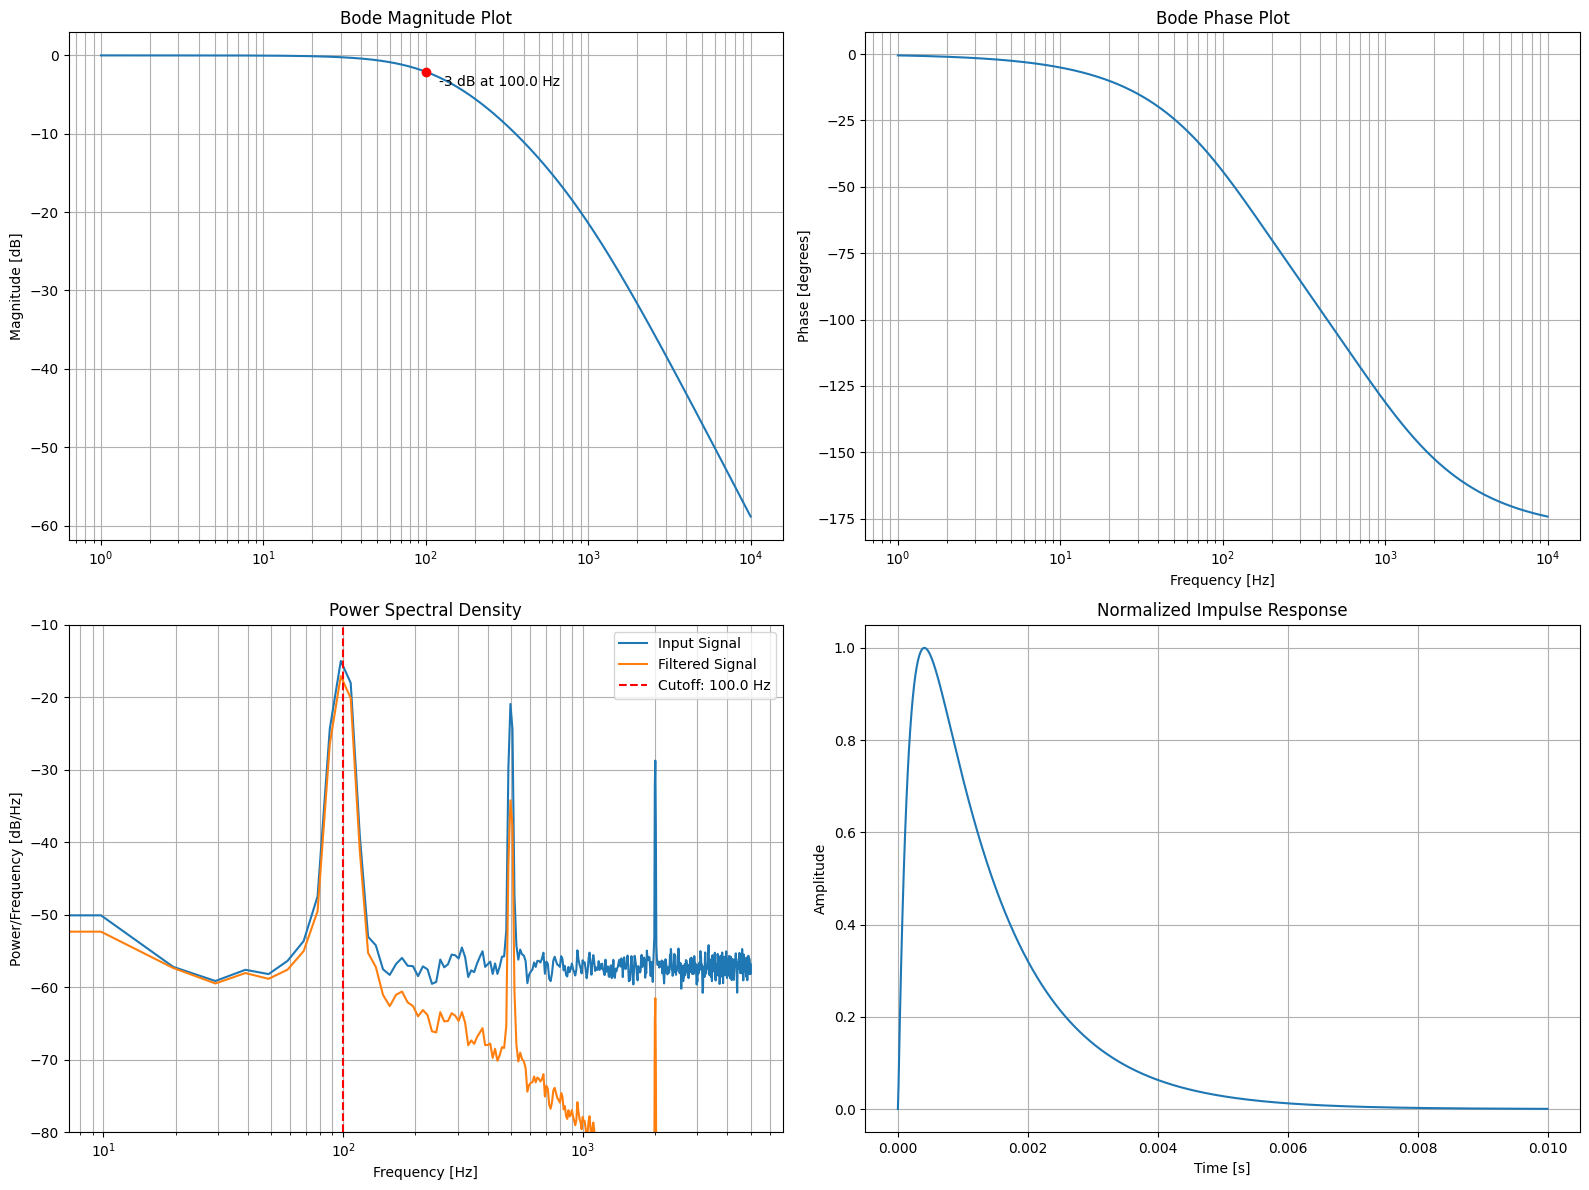

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, List
from scipy import signal
from scipy.fft import fft, fftfreq

# Signal Generation Functions
def generate_signal(
    sampling_freq: float,
    num_samples: int,
    amplitudes: List[float],
    frequencies: List[float],
    noise_variance: float = 0.0
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Generate a signal with multiple harmonics and optional Gaussian noise.
    """
    time_array = np.arange(num_samples) / sampling_freq
    clean_signal = np.zeros(num_samples)

    for amp, freq in zip(amplitudes, frequencies):
        if amp != 0 and freq != 0:
            clean_signal += amp * np.sin(2 * np.pi * freq * time_array)

    if noise_variance > 0:
        noise = np.random.normal(0, np.sqrt(noise_variance), num_samples)
        noisy_signal = clean_signal + noise
    else:
        noisy_signal = clean_signal.copy()

    return time_array, clean_signal, noisy_signal

# Filter Design Functions
def calculate_resistors(cutoff_freq: float, C1: float, C2: float) -> Tuple[float, float]:
    """
    Calculate resistor values for a second-order passive RC low-pass filter.
    """
    E12 = [1.0, 1.2, 1.5, 1.8, 2.2, 2.7, 3.3, 3.9, 4.7, 5.6, 6.8, 8.2]
    scale_factors = [1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6]

    a = 1 / (2 * np.pi * cutoff_freq)
    ideal_R1 = a / (C1 + np.sqrt(C1**2 + 4 * C1 * C2 * (1 - a**2 * 4 * np.pi**2 * C2 * cutoff_freq**2)))
    ideal_R2 = a / (C2 + np.sqrt(C2**2 + 4 * C1 * C2 * (1 - a**2 * 4 * np.pi**2 * C1 * cutoff_freq**2)))

    def find_nearest(ideal):
        best_match = None
        min_diff = float('inf')
        for sf in scale_factors:
            for val in E12:
                candidate = val * sf
                diff = abs(candidate - ideal)
                if diff < min_diff:
                    min_diff = diff
                    best_match = candidate
        return best_match

    R1 = find_nearest(ideal_R1)
    R2 = find_nearest(ideal_R2)

    return R1, R2

def get_transfer_function(R1: float, R2: float, C1: float, C2: float) -> signal.TransferFunction:
    """
    Create transfer function for the second-order RC low-pass filter.
    """
    num = [1]
    den = [R1*R2*C1*C2, R1*C1 + R2*C2 + R1*C2, 1]
    return signal.TransferFunction(num, den)

# New Impulse Response Function
def compute_impulse_response(tf: signal.TransferFunction, time_array: np.ndarray) -> np.ndarray:
    """
    Compute the normalized impulse response of the filter.

    Args:
        tf: Transfer function object
        time_array: Time array for the response

    Returns:
        Normalized impulse response
    """
    # Create impulse input
    impulse = np.zeros_like(time_array)
    impulse[0] = 1  # Dirac delta at t=0

    # Compute response
    _, response, _ = signal.lsim(tf, U=impulse, T=time_array)

    # Normalize the response
    if np.max(np.abs(response)) > 0:
        response /= np.max(np.abs(response))

    return response

# Plotting Functions
def create_comprehensive_plot(
    tf: signal.TransferFunction,
    cutoff_freq: float,
    input_signal: np.ndarray,
    output_signal: np.ndarray,
    sampling_freq: float,
    impulse_response: np.ndarray,
    impulse_time: np.ndarray
) -> None:
    """
    Create a comprehensive 2x2 subplot with all visualizations.
    """
    plt.figure(figsize=(16, 12))

    # 1. Bode Magnitude Plot
    plt.subplot(2, 2, 1)
    frequencies = np.logspace(np.log10(cutoff_freq)-2, np.log10(cutoff_freq)+2, 1000)
    w, mag, _ = signal.bode(tf, w=2*np.pi*frequencies)
    freq_hz = w / (2 * np.pi)

    plt.semilogx(freq_hz, mag)
    plt.title('Bode Magnitude Plot')
    plt.ylabel('Magnitude [dB]')
    plt.grid(which='both', axis='both')

    cutoff_idx = np.argmin(np.abs(freq_hz - cutoff_freq))
    plt.plot(freq_hz[cutoff_idx], mag[cutoff_idx], 'ro')
    plt.annotate(f'-3 dB at {cutoff_freq:.1f} Hz',
                (freq_hz[cutoff_idx], mag[cutoff_idx]),
                textcoords="offset points",
                xytext=(10,-10),
                ha='left')

    # 2. Bode Phase Plot
    plt.subplot(2, 2, 2)
    _, _, phase = signal.bode(tf, w=2*np.pi*frequencies)

    plt.semilogx(freq_hz, phase)
    plt.title('Bode Phase Plot')
    plt.ylabel('Phase [degrees]')
    plt.xlabel('Frequency [Hz]')
    plt.grid(which='both', axis='both')

    # 3. PSD Comparison
    plt.subplot(2, 2, 3)
    freq_in, psd_in = signal.welch(input_signal, fs=sampling_freq, nperseg=1024)
    freq_out, psd_out = signal.welch(output_signal, fs=sampling_freq, nperseg=1024)

    plt.semilogx(freq_in, 10 * np.log10(psd_in), label='Input Signal')
    plt.semilogx(freq_out, 10 * np.log10(psd_out), label='Filtered Signal')
    plt.axvline(x=cutoff_freq, color='r', linestyle='--', label=f'Cutoff: {cutoff_freq:.1f} Hz')

    plt.title('Power Spectral Density')
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Power/Frequency [dB/Hz]')
    plt.ylim(-80, -10)
    plt.grid(which='both', axis='both')
    plt.legend()

    # 4. Impulse Response
    plt.subplot(2, 2, 4)
    plt.plot(impulse_time, impulse_response)
    plt.title('Normalized Impulse Response')
    plt.xlabel('Time [s]')
    plt.ylabel('Amplitude')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Main Function
def main():
    """
    Main function to demonstrate the complete system.
    """
    # Signal generation parameters
    sampling_freq = 10000.0  # Hz
    num_samples = 10000
    amplitudes = [1.0, 0.5, 0.2]  # Amplitudes for 3 harmonics
    frequencies = [100.0, 500.0, 2000.0]  # Frequencies in Hz
    noise_variance = 0.01  # Add some noise

    # Generate test signal
    time_array, clean_signal, input_signal = generate_signal(
        sampling_freq, num_samples, amplitudes, frequencies, noise_variance
    )

    # Filter design parameters
    cutoff_freq = 100.0  # Hz
    C1 = 10e-9  # 10 nF
    C2 = 10e-9  # 10 nF

    # Calculate resistor values
    R1, R2 = calculate_resistors(cutoff_freq, C1, C2)

    print(f"Designed Second-Order RC Low-Pass Filter:")
    print(f"Cutoff Frequency: {cutoff_freq} Hz")
    print(f"Capacitors: C1 = {C1*1e9:.1f} nF, C2 = {C2*1e9:.1f} nF")
    print(f"Resistors: R1 = {R1:.1f} Ω, R2 = {R2:.1f} Ω")

    # Get transfer function
    tf = get_transfer_function(R1, R2, C1, C2)

    # Print transfer function
    print("\nTransfer Function:")
    print(f"H(s) = 1 / [")
    print(f"    {R1*R2*C1*C2:.3e} s² + {R1*C1 + R2*C2 + R1*C2:.3e} s + 1")
    print("]")

    # Filter the input signal
    t, output_signal, _ = signal.lsim(tf, U=input_signal, T=time_array)

    # Impulse response parameters
    impulse_duration = 0.01  # 10 ms for impulse response visualization
    impulse_time = np.linspace(0, impulse_duration, 1000)
    impulse_response = compute_impulse_response(tf, impulse_time)

    # Create comprehensive plot
    create_comprehensive_plot(
        tf=tf,
        cutoff_freq=cutoff_freq,
        input_signal=input_signal,
        output_signal=output_signal,
        sampling_freq=sampling_freq,
        impulse_response=impulse_response,
        impulse_time=impulse_time
    )

if __name__ == "__main__":
    main()